In [1]:
import pickle 
import sys
from graph_renderer import GraphRenderer
sys.path.append('..')
from Utils import get_recursive_basis
from Greedy import greedy, get_cost
import networkx as nx
import numpy as np
import pandas as pd
from itertools import combinations


In [2]:
# Define helper function
def summarize(graph, k):
    d = {x: x.replace("_", "*") for x in list(graph.nodes)}
    internal_graph = graph.copy()
    relabeled_graph = nx.relabel_nodes(internal_graph, d)

    nodes = list(relabeled_graph.nodes)
    recursive_basis = get_recursive_basis(relabeled_graph, nodes)
    similarity_df = pd.DataFrame(np.ones((len(nodes), len(nodes))), index=nodes, columns=nodes)
    summary_dag, _ = greedy(relabeled_graph, nodes, recursive_basis, k, similarity_df)

    vars_dict = {x: x.replace("_", ",\n").replace("*", "_") for x in list(summary_dag.nodes)}
    GraphRenderer.display_graph(summary_dag, vars_dict, layout='spring')

    topo_sort = list(nx.topological_sort(summary_dag))
    print(f"Nodes")
    for node in topo_sort:
        print(f"\t{node}")
    print(f"Edges:")
    for node in topo_sort:
        for edge in summary_dag.out_edges(node):
            print(f"\t{edge}") 

    return summary_dag

### Load the graph as created manually


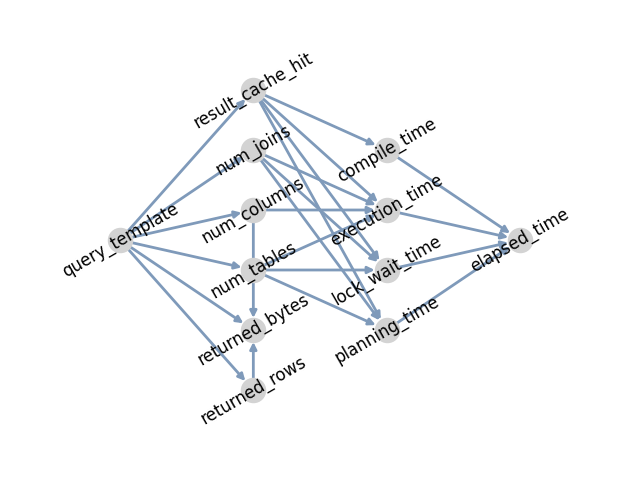

23

In [3]:
filepath = 'data/redshift_graph_manual.pkl'

with open(filepath, 'rb') as f:
    manual_graph = pickle.load(f)

GraphRenderer.display_graph(manual_graph, {})
len(manual_graph.edges)

### Generate a summary using CaGreS


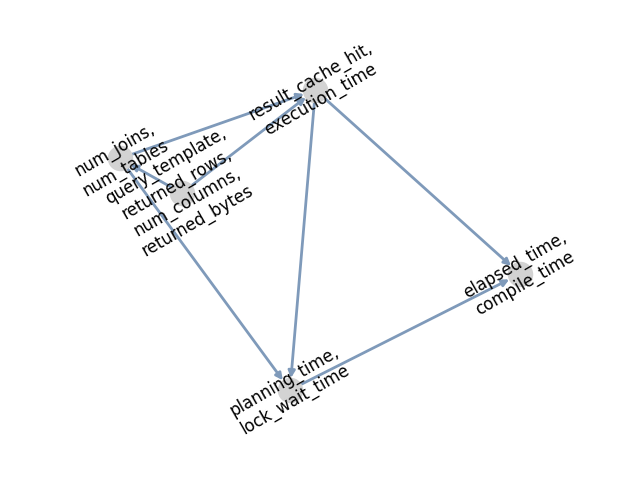

Nodes
	query*template_returned*rows_num*columns_returned*bytes
	num*joins_num*tables
	result*cache*hit_execution*time
	planning*time_lock*wait*time
	elapsed*time_compile*time
Edges:
	('query*template_returned*rows_num*columns_returned*bytes', 'num*joins_num*tables')
	('query*template_returned*rows_num*columns_returned*bytes', 'result*cache*hit_execution*time')
	('num*joins_num*tables', 'planning*time_lock*wait*time')
	('num*joins_num*tables', 'result*cache*hit_execution*time')
	('result*cache*hit_execution*time', 'planning*time_lock*wait*time')
	('result*cache*hit_execution*time', 'elapsed*time_compile*time')
	('planning*time_lock*wait*time', 'elapsed*time_compile*time')


7

In [4]:
manual_graph_summ = summarize(manual_graph, 5)
len(manual_graph_summ.edges)

### Load the graph as generated by GPT


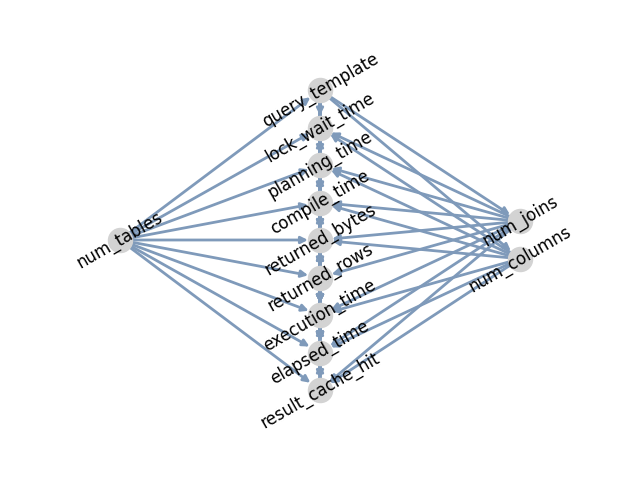

55

In [5]:
filepath = 'data/redshift_graph_gpt-4_acyclic.pkl'

with open(filepath, 'rb') as f:
    gpt_graph = pickle.load(f)

GraphRenderer.display_graph(gpt_graph, {})
len(gpt_graph.edges)

### Categorize GPT graph edges

In [6]:
common_edges = set()
conflicting_edges = set()
extra_edges = set()
for edge in gpt_graph.edges:
    if edge in manual_graph.edges:
        common_edges.add(edge)
        if edge == ('returned_rows', 'result_cache_hit'):
            print("added edge to common edges")
    elif edge[::-1] in manual_graph.edges:
        conflicting_edges.add(edge)
        if edge == ('returned_rows', 'result_cache_hit'):
            print("added edge to conflicting edges")
    else:
        extra_edges.add(edge)
        if edge == ('returned_rows', 'result_cache_hit'):
            print("added edge to extra edges")
    
missing_edges = set()
for edge in manual_graph.edges:
    if edge not in common_edges and edge[::-1] not in conflicting_edges:
        missing_edges.add(edge)


print(f"Common edges: {len(common_edges)}")
print(f"\t{common_edges}")
print(f"Conflicting edges: {len(conflicting_edges)}")
print(f"\t{conflicting_edges}")
print(f"Missing edges: {len(missing_edges)}")
print(f"\t{missing_edges}")
print(f"Extra edges: {len(extra_edges)}")
print(f"\t{extra_edges}")

Common edges: 21
	{('returned_rows', 'returned_bytes'), ('num_tables', 'execution_time'), ('query_template', 'result_cache_hit'), ('execution_time', 'elapsed_time'), ('num_joins', 'lock_wait_time'), ('num_columns', 'returned_bytes'), ('result_cache_hit', 'execution_time'), ('result_cache_hit', 'compile_time'), ('num_joins', 'execution_time'), ('query_template', 'returned_bytes'), ('compile_time', 'elapsed_time'), ('query_template', 'num_joins'), ('num_tables', 'planning_time'), ('lock_wait_time', 'elapsed_time'), ('num_columns', 'execution_time'), ('planning_time', 'elapsed_time'), ('query_template', 'num_columns'), ('result_cache_hit', 'planning_time'), ('query_template', 'returned_rows'), ('num_joins', 'planning_time'), ('num_tables', 'lock_wait_time')}
Conflicting edges: 1
	{('num_tables', 'query_template')}
Missing edges: 1
	{('result_cache_hit', 'lock_wait_time')}
Extra edges: 33
	{('num_columns', 'result_cache_hit'), ('planning_time', 'compile_time'), ('num_tables', 'returned_row

### Robustness to edge deletion


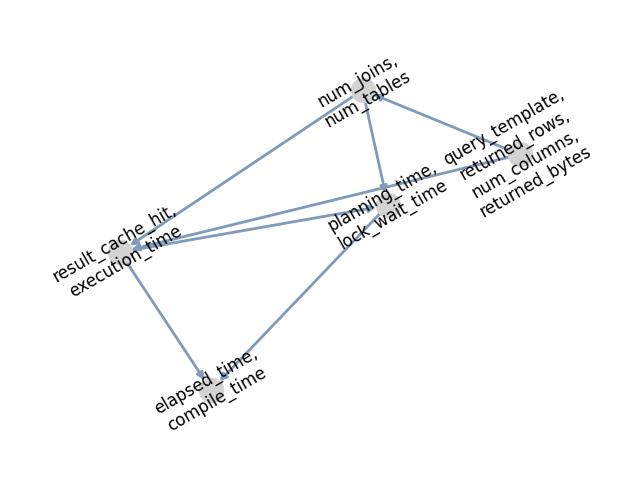

Nodes
	query*template_returned*rows_num*columns_returned*bytes
	num*joins_num*tables
	result*cache*hit_execution*time
	planning*time_lock*wait*time
	elapsed*time_compile*time
Edges:
	('query*template_returned*rows_num*columns_returned*bytes', 'num*joins_num*tables')
	('query*template_returned*rows_num*columns_returned*bytes', 'result*cache*hit_execution*time')
	('num*joins_num*tables', 'planning*time_lock*wait*time')
	('num*joins_num*tables', 'result*cache*hit_execution*time')
	('result*cache*hit_execution*time', 'planning*time_lock*wait*time')
	('result*cache*hit_execution*time', 'elapsed*time_compile*time')
	('planning*time_lock*wait*time', 'elapsed*time_compile*time')


7

In [7]:
deletion_graph = manual_graph.copy()
deletion_graph.remove_edges_from(missing_edges)
deletion_graph_summ = summarize(deletion_graph, 5)
len(deletion_graph_summ.edges)

In [8]:
print(set(manual_graph_summ.edges) == set(deletion_graph_summ.edges))

True


### Robustness to edge addition

Added edges: [('lock_wait_time', 'returned_rows'), ('num_columns', 'lock_wait_time'), ('num_columns', 'planning_time'), ('returned_bytes', 'elapsed_time'), ('returned_bytes', 'execution_time')]



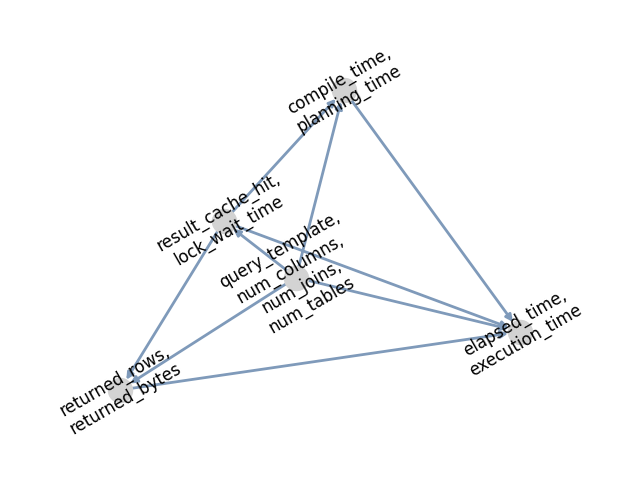

Nodes
	query*template_num*columns_num*joins_num*tables
	result*cache*hit_lock*wait*time
	compile*time_planning*time
	returned*rows_returned*bytes
	elapsed*time_execution*time
Edges:
	('query*template_num*columns_num*joins_num*tables', 'returned*rows_returned*bytes')
	('query*template_num*columns_num*joins_num*tables', 'result*cache*hit_lock*wait*time')
	('query*template_num*columns_num*joins_num*tables', 'compile*time_planning*time')
	('query*template_num*columns_num*joins_num*tables', 'elapsed*time_execution*time')
	('result*cache*hit_lock*wait*time', 'compile*time_planning*time')
	('result*cache*hit_lock*wait*time', 'elapsed*time_execution*time')
	('result*cache*hit_lock*wait*time', 'returned*rows_returned*bytes')
	('compile*time_planning*time', 'elapsed*time_execution*time')
	('returned*rows_returned*bytes', 'elapsed*time_execution*time')


9

In [9]:
add_graph = manual_graph.copy()

if False:
    # The edges `to_add` were originally derived this way, but the output of this depends on package versioning,
    # which affects the shuffling. For reproducibility of the paper case study, we hard-code the edges below.
    extra_edges_shuffled = [edge for edge in extra_edges]
    np.random.seed(42)
    np.random.shuffle(extra_edges_shuffled)
    to_add = list(extra_edges_shuffled)[:5]

to_add = [
    ("lock_wait_time", "returned_rows"),
    ("num_columns", "lock_wait_time"),
    ("num_columns", "planning_time"),
    ("returned_bytes", "elapsed_time"),
    ("returned_bytes", "execution_time"),
]

add_graph.add_edges_from(to_add)
print(f"Added edges: {to_add}")

add_graph_summ = summarize(add_graph, 5)
len(add_graph_summ.edges)